In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from keras import optimizers
from glob import glob
import gdal
import os
import src.segtools as segtools
from PIL import Image
%matplotlib inline
from keras.models import model_from_json

def import_model(model_json, model_weights):
    '''
    Imports a keras model architecture and 
    associated weights.

    Parameters:
    -----------
    model_json : <str> of keras model in json
    format

    model_weights : <str> of keras model parameters weights
    '''

    json_file = open(model_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_weights)
    return(loaded_model)

Using TensorFlow backend.


In [2]:
model_dirc = '/contents/fit_models/201801011947'
model_json = '%s/seg_net.json'%(model_dirc)
model_weight = '%s/seg_net.h5'%(model_dirc) 
model = import_model(model_json, model_weight)
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', \
                     optimizer=opt, metrics=['categorical_accuracy'])
print('Model compiled!')

Model compiled!


In [7]:
num_classes = 2
nrows, ncols = 256, 256
x_val, y_val = segtools.get_xy_data('/contents/images/val')
#x_val = segtools.pre_process_x(x_val)
#y_val = segtools.pre_process_y(y_val, num_classes)

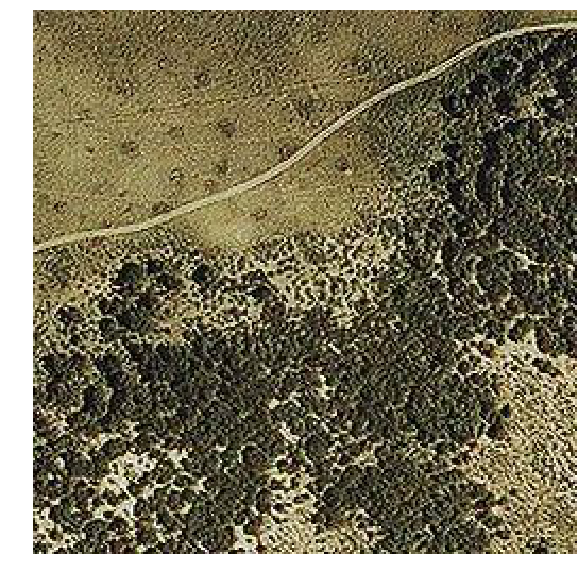

In [42]:
f, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(x_val[209])
ax.axis('off')
f.savefig('/contents/images/example_S.png', bbox_inches='tight', pad_inches=0)

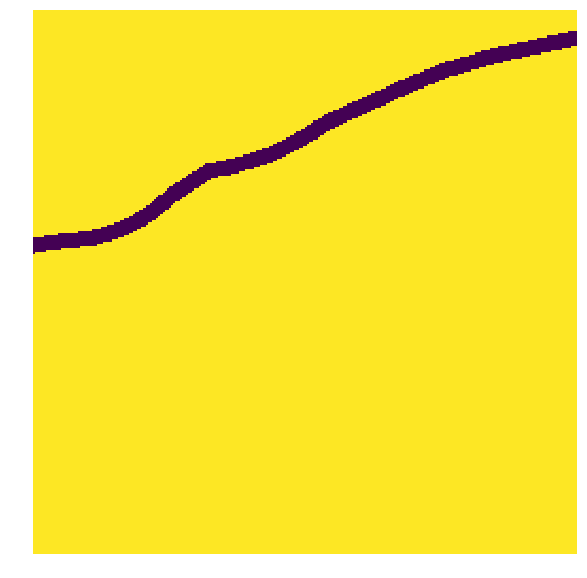

In [41]:
f, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(y_val[209][:,:,0])
ax.axis('off')
f.savefig('/contents/images/example_M.png', bbox_inches='tight', pad_inches=0)

In [13]:
class_weights = segtools.get_weights(y_val)
print(class_weights)

[ 19.6088894    0.51308292]


In [14]:
pr = model.predict(x_val)
predictions = []
for i in range(len(pr)):
    predictions.append(pr[i].reshape((256,256,num_classes)))
predictions = np.array(predictions)
norm_pred = segtools.normalize_stack(predictions[:,:,:,0])

0.0261658325402


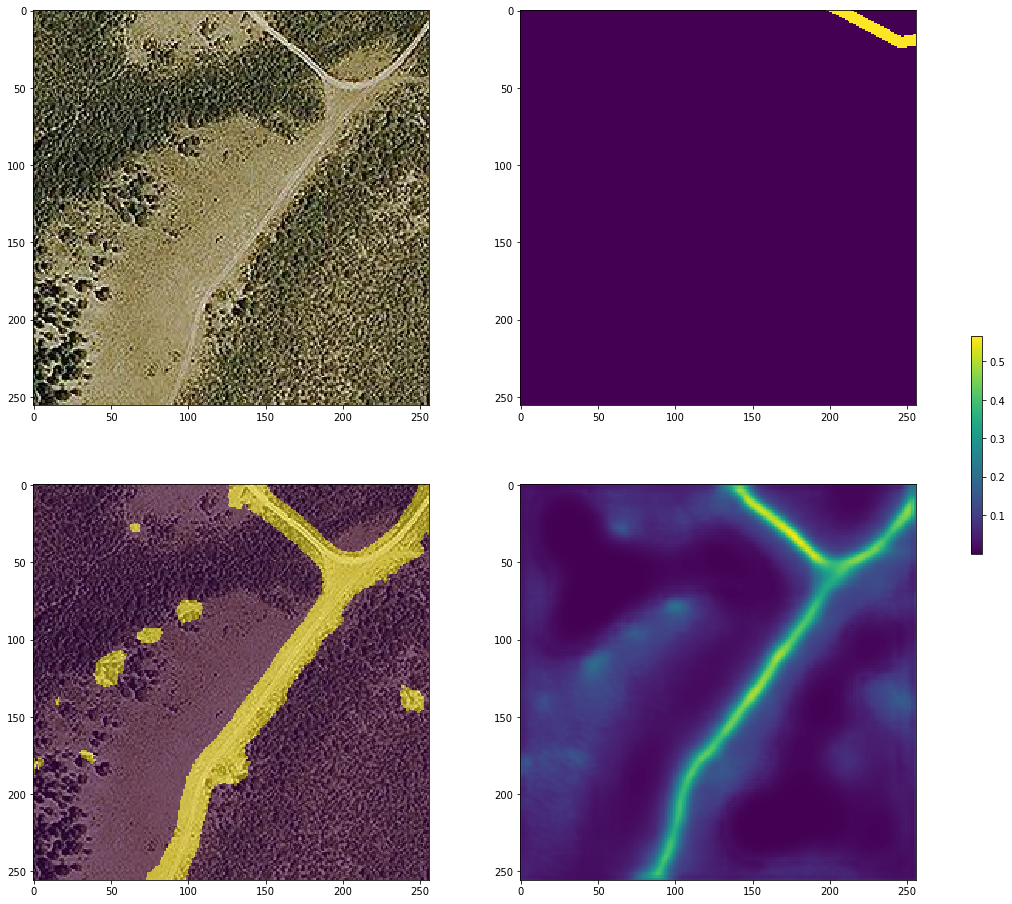

In [35]:
thr=class_weights[1]/class_weights[0]
print(thr)
thr=0.13
f, ax = plt.subplots(2,2, figsize=(20, 16))
sample=np.random.randint(0, len(x_val))
ax[0,0].imshow(x_val[sample].astype('float32'))
ax[0,1].imshow(y_val[sample].reshape(256,256,num_classes)[:,:,0])
ax[1,0].imshow(x_val[sample].astype('float32'))
mask = np.zeros((256,256))
mask[norm_pred[sample]>=thr] = 1
ax[1,0].imshow(mask,alpha=0.5)

im = ax[1,1].imshow(norm_pred[sample])
f.colorbar(im, ax=ax.ravel().tolist(), shrink=0.25)